# Number of people in each relevant sector



In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf
# from math import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

import population_tools

In [3]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2019/1.3 labour')
RESULTS_FOLDER.mkdir(exist_ok=True)

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

In [4]:
WBGT_FOLDER = DATA_SRC / 'lancet' / 'wbgt'

In [7]:
EMPLOYMENT_DATA_FILE = DATA_SRC / 'lancet' / 'employment to population data 2020 projections.xlsx'

In [10]:
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [11]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')
COUNTRIES_LOOKUP.NAME0 = COUNTRIES_LOOKUP.NAME0.str.lower()

## Load employment data and assign GPW Grid ID codes

In [8]:
employment = pd.read_excel(EMPLOYMENT_DATA_FILE, 
              sheet_name='Country - emp-to-pop ratio')

In [15]:
employment['country_gpwid'] = employment['Country Code'].replace(COUNTRIES_LOOKUP.set_index('ISOCODE').GRIDCODE)

In [17]:
emp_agri = employment[employment['Economic activity'] == 'Agriculture (Broad sector)']
emp_serv = employment[employment['Economic activity'] == 'Services (Broad sector)']
emp_indu = employment[employment['Economic activity'] == 'Industry (Broad sector)']

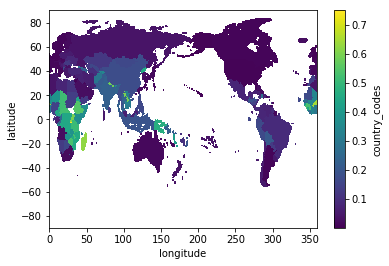

In [20]:
# Assign to grid for example year and plot
year = '2018'
out_data = xr.zeros_like(COUNTRIES_RASTER.country_codes)
filldata = emp_agri[['country_gpwid', year]]
for idx, row in filldata.iterrows():
    out_data = xr.where(COUNTRIES_RASTER.country_codes == row.country_gpwid, row[year], out_data)
out_data = xr.where(COUNTRIES_RASTER.country_codes == 32767, np.nan, out_data)
out_data = xr.where(out_data == 0, np.nan, out_data)

out_data.plot()

In [22]:
sectors = {
    'agri': 'Agriculture (Broad sector)',
'serv': 'Services (Broad sector)',
'indu': 'Industry (Broad sector)'
}

years = np.arange(2000, MAX_YEAR+1)

results = {}

for short, sector_name in tqdm_notebook(sectors.items()):
    
    year_results = []
    for year in tqdm_notebook(years):
        out_data = xr.zeros_like(COUNTRIES_RASTER.country_codes)

        emp = employment[employment['Economic activity'] == sector_name]
        
        for idx, row in emp.iterrows():
            out_data = xr.where(COUNTRIES_RASTER.country_codes == row.country_gpwid, row[f'{year}'], out_data)
        
        out_data = xr.where(COUNTRIES_RASTER.country_codes == 32767, np.nan, out_data)
        out_data = xr.where(out_data == 0, np.nan, out_data)
        year_results.append(out_data)
        
    results[short] = xr.concat(year_results, dim=pd.Index([int(y) for y in years], name='year'))

In [23]:
pcts_in_emp = xr.Dataset(results)

In [24]:
pcts_in_emp

<xarray.Dataset>
Dimensions:    (latitude: 360, longitude: 720, year: 19)
Coordinates:
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * year       (year) int64 2000 2001 2002 2003 2004 ... 2015 2016 2017 2018
Data variables:
    agri       (year, latitude, longitude) float64 nan nan nan ... nan nan nan
    serv       (year, latitude, longitude) float64 nan nan nan ... nan nan nan
    indu       (year, latitude, longitude) float64 nan nan nan ... nan nan nan

In [25]:
pcts_in_emp.to_netcdf(DATA_SRC / 'lancet' /'labour_capacity' / 'era_30min_pcts' / 'employment_pcts_all_years.nc')

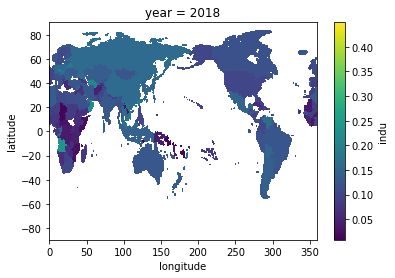

In [26]:
pcts_in_emp['indu'].sel(year=2018).plot()

# OLD STUFF BELOW

In [6]:
# UN_DEMOGRAPHICS_TABLE = pd.read_csv(UN_DEMOGRAPHICS_FILE)
# # Add the percentages from the population totals
# UN_DEMOGRAPHICS_TABLE['PopPct'] = UN_DEMOGRAPHICS_TABLE.groupby(['LocID','Time']).PopTotal.apply(lambda g: g/g.sum())

In [3]:
# # Load a country shapefile for rasterising
# COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# # Translate to match raster coordinates
# COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# # Remove missing UN A3 code fields, convert to int and set as index
# COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
# COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
# COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
# COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
# COUNTRIES = COUNTRIES.set_index('un_a3')

In [6]:
# emp_country_lookup = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
#                      sheet_name='CountryCode')

# emp_country_lookup.columns = ['country_name', 'country_iso3']

In [9]:
# def un_fuck_names(s):
#     parts = s.split(',')
#     if len(parts) == 2:
#         return (parts[1] + ' ' + parts[0]).strip().lower()
#     else: 
#         return s.strip().lower()
# employment.Country = employment.Country.apply(un_fuck_names)
# employment['country_iso3'] = employment.Country.replace(emp_country_lookup.set_index('country_name').country_iso3)
# employment['country_gpwid'] = employment.Country.replace(COUNTRIES_LOOKUP.set_index('NAME0').GRIDCODE)

In [8]:
agri = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Agemp-to-pop ratio', index_col=0)

indu = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Indemp-to-pop ratio', index_col=0)

serv = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Servemp-to-pop ratio', index_col=0)

In [9]:
# Tidy up the table and convert the date columns to numbers
agri = agri.drop('Economic activity', axis='columns')
agri.columns = agri.columns.astype(int)

indu = indu.drop('Economic activity', axis='columns')
indu.columns = indu.columns.astype(int)

serv = serv.drop('Economic activity', axis='columns')
serv.columns = serv.columns.astype(int)

In [10]:
# Add country data to sector tables
c = COUNTRIES[['iso_a3', 'iso_n3', 'geometry']]
c = c.reset_index().set_index('iso_a3')

agri = agri.join(c)
indu = indu.join(c)
serv = serv.join(c)